Training data was taken from kaggle: 
https://www.kaggle.com/utkarshxy/stock-markettweets-lexicon-data

In [15]:
%load_ext nb_black
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pickle


RANDOM_STATE = 0

import demoji

demoji.download_codes()
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gelezis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<IPython.core.display.Javascript object>

# Load Data

In [6]:
df_tweets_labelled = pd.read_csv("data/tweets_labelled.csv", sep=";").set_index("id")
df_tweets_labelled = df_tweets_labelled.dropna()

<IPython.core.display.Javascript object>

In [7]:
df_tweets_labelled

,created_at,text,sentiment
id,,,
77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...
75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive
739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive
254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='sentiment', ylabel='count'>

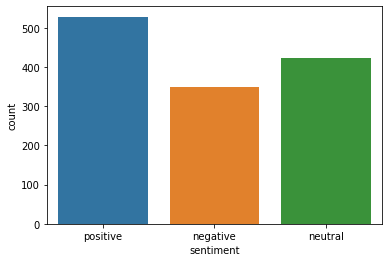

<IPython.core.display.Javascript object>

In [7]:
sns.countplot(x="sentiment", data=df_tweets_labelled)

# Data Wrangling

In [8]:
df_tweets_labelled_demoji = df_tweets_labelled.copy()
df_tweets_labelled_demoji["text"] = df_tweets_labelled_demoji["text"].map(
    lambda x: demoji.replace_with_desc(x, sep=" ")
)
df_tweets_labelled_demoji

,created_at,text,sentiment
id,,,
77522,2020-04-15 01:03:46+00:00,RT @RobertBeadles: Yo collision \nEnter to WIN...,positive
661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n fuel pu...,negative
413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...
75519,2020-04-15 06:00:10+00:00,#stocks back from the recovery room: https://t...,positive
739234,2020-07-01 11:29:10+00:00,RT @MacroCharts: Breadth – expanding last week...,positive
254379,2020-04-29 02:21:50+00:00,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral


<IPython.core.display.Javascript object>

In [9]:
def clean_tweets(tweets: list) -> list:
    processed_tweets = []

    for tweet in tweets:
        # remove stock market tickers like $AAPL
        processed_tweet = re.sub(r"\$\w*", "", tweet)
        # remove old style retweet text "RT"
        processed_tweet = re.sub(r"^RT[\s]+", "", processed_tweet)
        # remove hyperlinks
        processed_tweet = re.sub(r"http\S+", "", processed_tweet)
        # remove the hash # sign from the word
        processed_tweet = re.sub(r"#", "", processed_tweet)
        # remove digit characters
        processed_tweet = re.sub("[0-9]", " ", processed_tweet)
        # remove all other special characters
        processed_tweet = re.sub(r"\W", " ", processed_tweet)

        processed_tweets.append(processed_tweet)

    return processed_tweets

<IPython.core.display.Javascript object>

In [10]:
processed_tweets_train = clean_tweets(df_tweets_labelled_demoji["text"].values)

<IPython.core.display.Javascript object>

In [16]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    ngram_range=(1, 2),
    stop_words=stopwords.words("english"),
)
X_train_tfidf = vectorizer.fit_transform(processed_tweets_train)
print(vectorizer.get_feature_names())

['aapl', 'able', 'account', 'action', 'actually', 'adammancini', 'added', 'ads', 'advertising', 'ago', 'ahead', 'ai', 'alert', 'alerts', 'already', 'also', 'always', 'amazon', 'america', 'amp', 'amp co', 'analysis', 'analyst', 'analysts', 'announce', 'announce earnings', 'another', 'app', 'apple', 'april', 'around', 'arrow', 'asset', 'ath', 'available', 'average', 'away', 'awox', 'back', 'backhand', 'backhand index', 'bad', 'bag', 'bank', 'banknifty', 'banks', 'bar', 'bar chart', 'based', 'bear', 'bear market', 'bearish', 'bears', 'beat', 'believe', 'bell', 'best', 'better', 'bias', 'bid', 'big', 'bill', 'billion', 'biontech', 'biotech', 'bit', 'bitcoin', 'bitcoin ethereum', 'black', 'bonds', 'book', 'bottom', 'bought', 'bounce', 'bounced', 'boycott', 'bp', 'brands', 'break', 'breakdown', 'breaking', 'breakout', 'brokerages', 'brokerages stocks', 'btc', 'btc trade', 'bubble', 'building', 'bull', 'bullish', 'bulls', 'bullseye', 'business', 'business markets', 'business money', 'button',

<IPython.core.display.Javascript object>

# Baseline model

In [30]:
X_train_full = X_train_tfidf
y_train_full = df_tweets_labelled["sentiment"]

<IPython.core.display.Javascript object>

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_full,
)

<IPython.core.display.Javascript object>

## Logistic regression

In [32]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

<IPython.core.display.Javascript object>

In [33]:
# Training classification report
y_pred_train = log_reg.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86       278
     neutral       0.85      0.90      0.88       339
    positive       0.91      0.86      0.89       423

    accuracy                           0.88      1040
   macro avg       0.87      0.88      0.87      1040
weighted avg       0.88      0.88      0.88      1040



<IPython.core.display.Javascript object>

In [36]:
# Validation classification report
y_pred_val = log_reg.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

    negative       0.51      0.56      0.53        70
     neutral       0.51      0.54      0.52        85
    positive       0.58      0.50      0.54       105

    accuracy                           0.53       260
   macro avg       0.53      0.53      0.53       260
weighted avg       0.53      0.53      0.53       260



<IPython.core.display.Javascript object>

In [37]:
def scores(model, X_train: pd.DataFrame, y_train: pd.DataFrame, metric: str) -> float:
    score = -1 * cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
    return score

<IPython.core.display.Javascript object>

In [38]:
log_reg = LogisticRegression(class_weight="balanced")

cross_f1_score = scores(log_reg, X_train_full, y_train_full, "f1_micro")
cross_f1_score = -1 * sum(cross_f1_score) / len(cross_f1_score)
print(f"Cross validation F1 score is {cross_f1_score}")

Cross validation F1 score is 0.57


<IPython.core.display.Javascript object>

# Pickle Final Model

In [23]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train_full, y_train_full)

LogisticRegression(class_weight='balanced')

<IPython.core.display.Javascript object>

In [24]:
# Pickle model
pkl_filename = "logistic_reg.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(log_reg, file)

<IPython.core.display.Javascript object>

In [43]:
# Pickle vectorizer
pkl_filename = "vectorizer.pkl"
with open(pkl_filename, "wb") as file:
    pickle.dump(vectorizer, file)

<IPython.core.display.Javascript object>